# TP2
### Étudiant
    1. Félix Moreau 1846157
    2. Axel Massucci Templier 1837967
    3. Hermann Noubissie Noussa 1901259
    4. Pierre-Olivier Côté 1848609


In [2]:
import yfinance as yf 
from pandas_datareader import data, wb
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
import math as mt
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import talib
import pylab
from sklearn import preprocessing

In [3]:
start_sp = datetime.datetime(2012,3,31)
end_sp = datetime.datetime(2020, 12,31)

# Use Vanguard ETF
# SP500 Index + 11 Industry
#BLack_ETF=['IVV','IWF','IJH','IJR','IWM','IVW']
BLack_ETF=['IVV','IWF','IJH','IJR','IWM','IWD','ITOT','IVW','IWB','IWR','DVY',
           'IVE','IWP','IWS','IWV','IUSG','IWO','IWN','IBB','IJK','IUSV',
           'OEF','IJS','IJJ','IYW','IHI','IJT','ITA','IGV','IYH','SOXX','EWC',
           'IGM','IYF','JKE','SUSA','IDU','IYY','IYG','JKD','IYC','IYJ','JKG',
           'IWC','IYK','JKF','JKH','IYT','JKI','IYZ','IGE','IYE','JKL','IYM',
           'JKJ','JKK','IGN']

In [4]:
def get_Data_bin(ticker):
    Data = yf.download(ticker, start=start_sp, end=end_sp,group_by="ticker")
    rendement = pd.DataFrame(Data['Adj Close'].T.pct_change())
    rendement_bin = pd.DataFrame(np.where(rendement['Adj Close'].shift(-1) > rendement['Adj Close'], 1, 0),
                                index = rendement.index)
    return rendement_bin, Data

In [5]:
def data_preprocessing(ticker, Data):
    dataset = pd.DataFrame(index = Data.index)
    dataset['H-L'] = Data['High'] - Data['Low']
    dataset['O-C'] = Data['Close'] - Data['Open']
    
    dataset['ma_5'] = Data['Close'].rolling(window=5).mean()
    dataset['ma_10'] = Data['Close'].rolling(window=10).mean()
    
    dataset['EWMA_12'] = Data['Close'].ewm(span=12).mean()

    dataset['std_5'] = Data['Close'].rolling(window=5).std()
    dataset['std_10'] = Data['Close'].rolling(window=10).std()
    
    dataset['Williams %R'] = talib.WILLR(Data['High'].values,
                                         Data['Low'].values, Data['Close'].values, 7)
    #RSI
    dataset['RSI'] = talib.RSI(Data['Close'], timeperiod = 14)
    #conditions  = [dataset['RSI'] >= 70, (dataset['RSI'] < 70) & (dataset['RSI']> 30), dataset['RSI'] <= 30 ]
    #choices     = [ -1, 0, 1 ]
    #dataset['RSI'] = np.select(conditions, choices, default=np.nan)

    #MFI
    dataset['MFI'] = talib.MFI(Data['High'], Data['Low'], Data['Close'], Data['Volume'], timeperiod=14)
    #conditions  = [dataset['MFI'] >= 70, (dataset['MFI'] < 70) & (dataset['MFI']> 30), dataset['MFI'] <= 30 ]
    #choices     = [ -1, 0, 1 ]
    #dataset['MFI'] = np.select(conditions, choices, default=np.nan)
    
    #BBANDS
    #dataset['BBANDS_UP'], centre, dataset['BBANDS_DOWN'] = talib.BBANDS(
    #    Data['Close'],timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
                                                                                       
    #STOCHASTIC  
    dataset['STO_k'], dataset['STO_d'] = talib.STOCH(Data['High'], Data['Low'], Data['Close'],
                         fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    #k = dataset['STO_k']
    #d = dataset['STO_d']
    #conditions  = [(k>=80)&(d>=80),(k<80)&(d<80)&(k>=20)&(d>=20),(k<20)&(d<20)]
    #dataset['STO'] = np.select(conditions, choices, default=np.nan)
    
    #MACD
    macd, dataset['MACD'], macdhist = talib.MACD(Data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
    #conditions  = [dataset['MACD'] < 0,dataset['MACD']==0 , dataset['RSI'] > 0 ]
    #choices     = [ -1, 0, 1 ]
    #dataset['MACD'] = np.select(conditions, choices, default=np.nan)
    
    #ADX
    dataset['ADX'] = talib.ADX(Data['High'], Data['Low'], Data['Close'], timeperiod=14)
    
    #MA
    dataset['MA'] = talib.MA(Data['Close'], timeperiod=30, matype=0)
    
    #SMA
    dataset['SMA'] = talib.SMA(Data['Close'], timeperiod=30)
    
    #SAR
    dataset['SAR'] = talib.SAR(np.array(Data['High']), np.array(Data['Low']), 0.2, 0.2)
    
    return dataset

#### Nous avons décidé de laisser en donné brute pour chaque signal afin que le modèle découvre lui-même a partir de quel nombre on doit vendre ou acheter!!

In [5]:
X=pd.DataFrame()
Y=pd.DataFrame()
for etf in BLack_ETF:
    Y_bin, Data = get_Data_bin(etf)
    dataset_ini = data_preprocessing(etf, Data)
    X = pd.concat([X,dataset_ini])
    Y = pd.concat([Y,Y_bin])
X['Y'] = Y
X = X.dropna()
Y = X['Y']
X1 = X.drop(columns = ['Y'])
X = pd.DataFrame(preprocessing.scale(X1), columns=X1.columns)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [6]:
df = pd.DataFrame([data.DataReader(etf, 'yahoo', start_sp, end_sp)['Adj Close'] for etf in BLack_ETF]).T
df.columns = BLack_ETF
rendement = df.pct_change()

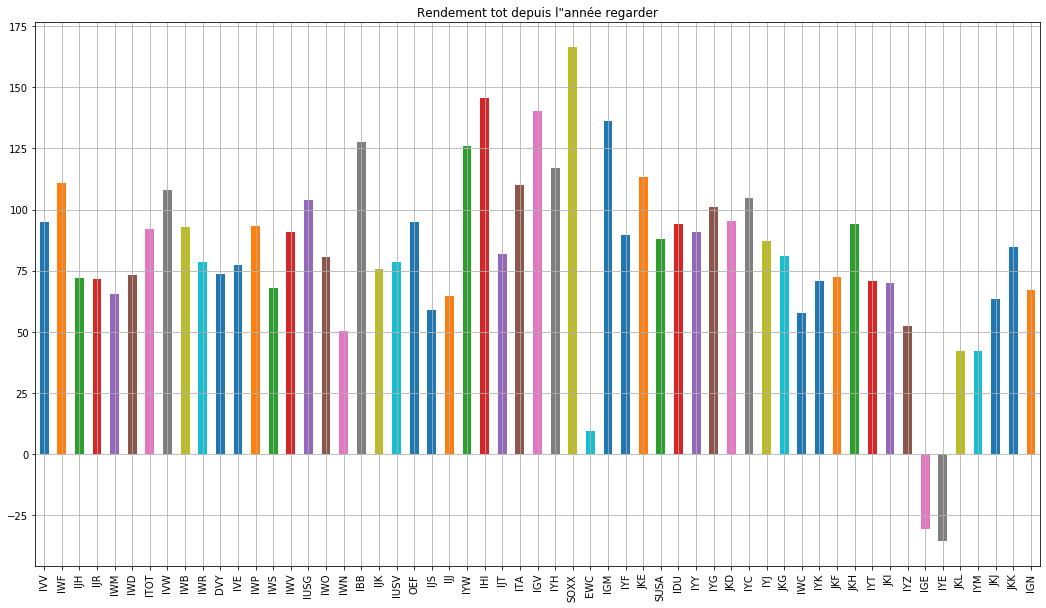

In [13]:
somme = rendement.sum()*100
somme.plot(kind='bar', grid=True, title = 'Rendement tot depuis l"année regarder',figsize=(18, 10))

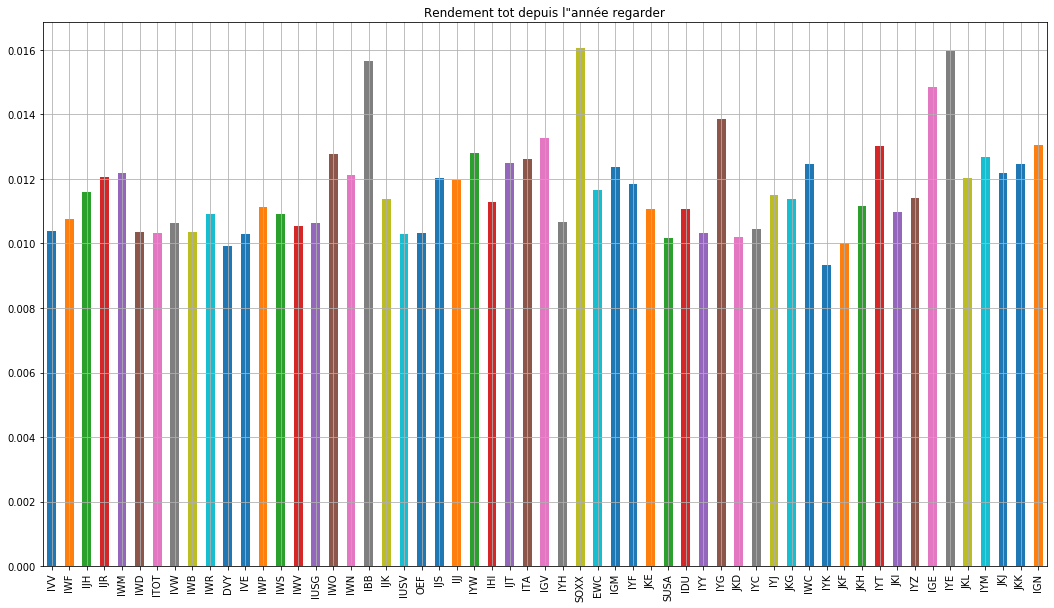

In [12]:
allo=rendement.std()
allo.plot(kind='bar', grid=True, title = 'Rendement tot depuis l"année regarder',figsize=(18, 10))

# 1) Modele Logit

In [9]:
def calculate_aic(n, mse, num_params):
    aic = n * mt.log(mse) + 2 * num_params
    return aic

In [10]:
def calculModelLogit(X,Y):
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.30, random_state = 0)
    ModeleLogit = LogisticRegression()
    TrainFit = ModeleLogit.fit(trainX, trainY)
    TrainScores = ModeleLogit.score(trainX, trainY)
    print('Train score=',TrainScores)
    
    TestsScore = ModeleLogit.score(testX, testY)
    print('Test score=',TestsScore)
    
    predictions = ModeleLogit.predict(testX)
    proba = ModeleLogit.predict_proba(testX)[:,1]
    
    mse = mean_squared_error(testY, predictions)
    aic = calculate_aic(len(testY),mse,len(X.T))
    print('AIC score :',aic)
    return predictions, TrainScores, TestsScore, aic, ModeleLogit.coef_, testY, ModeleLogit, proba, trainY, trainX

In [11]:
def getROC(yTest, prediction, proba):
    fpr, tpr, thres = roc_curve(yTest, proba)
    ac = roc_auc_score(yTest, prediction)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % ac)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [12]:
def getMC(yTest, prediction):
    matrice = confusion_matrix(yTest, prediction)
    print(matrice) 

In [13]:
def verificationCoef(coef, data):
    dataAmeliorer = data
    for i in range(0,len(coef)):
        if coef[i] < -0.5:
            sigle = data.columns[i]
#print(sigle)
            if sigle in dataAmeliorer.columns:
                dataAmeliorer = dataAmeliorer.drop(sigle, axis="columns")
    return dataAmeliorer

In [14]:
predictions, TrainScores, TestsScorelogit, aic, coefficientModel, testY, model, proba, trainY, trainX = calculModelLogit(X, Y)

Train score= 0.7168115609002591
Test score= 0.7209877278684618
AIC score : -42820.641616648725


Pour l'echantillon d'entrainement

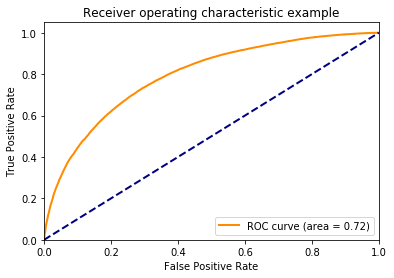

In [15]:
getROC(trainY, model.predict(trainX), model.predict_proba(trainX)[:,1])

In [16]:
getMC(trainY, model.predict(trainX))

[[30950  9432]
 [12751 25200]]


Pour l'echantillon test

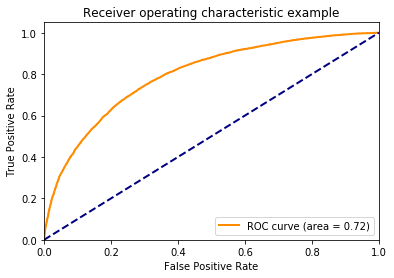

In [17]:
getROC(testY, predictions, proba)

In [18]:
getMC(testY, predictions)

[[13241  3968]
 [ 5399 10964]]


In [19]:
variableImportante2 = pd.DataFrame(coefficientModel, columns=X1.columns).T
var2 = variableImportante2.sort_values(by=0,ascending = False)
var2

,0
ma_5,2.464477
STO_k,0.970829
EWMA_12,0.580303
STO_d,0.165222
H-L,0.141650
std_10,0.057532
ADX,0.010245
MFI,-0.012383
MACD,-0.045371
ma_10,-0.094168


## Changer les paramètres afin d'avoir une meilleure classification

In [20]:
#https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
feature_list = list(X1.columns)
rfe = RFE(model,8)
rfe = rfe.fit(X, Y)
print(rfe.support_)
print(rfe.ranking_)
rapport = rfe.support_

nouvelleBD = X
## On veut visualiser les variables qui ne sont pas sélectionnées
for i in range(0,len(rapport)):
    if rapport[i]==False :
        sigle = X
        print("Le paramètre:",feature_list[i], "n'est pas selectionné")
        nouvelleBD = nouvelleBD.drop(columns = feature_list[i])

[False  True  True  True  True False False  True False False  True False
 False False  True  True False]
[ 6  1  1  1  1  5  7  1  2 10  1  4  8  9  1  1  3]
Le paramètre: H-L n'est pas selectionné
Le paramètre: std_5 n'est pas selectionné
Le paramètre: std_10 n'est pas selectionné
Le paramètre: RSI n'est pas selectionné
Le paramètre: MFI n'est pas selectionné
Le paramètre: STO_d n'est pas selectionné
Le paramètre: MACD n'est pas selectionné
Le paramètre: ADX n'est pas selectionné
Le paramètre: SAR n'est pas selectionné


In [21]:
predictions, TrainScores, TestsScorelogit, aic, coefficientModel, testY, model, proba, trainY, trainX = calculModelLogit(nouvelleBD, Y)

Train score= 0.7153307035349087
Test score= 0.7187835100679137
AIC score : -42574.46245677361


Pour l'echantillon d'entrainement 

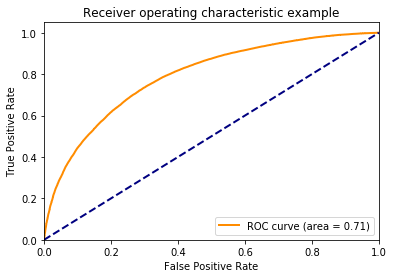

In [22]:
getROC(trainY, model.predict(trainX), model.predict_proba(trainX)[:,1])

In [23]:
getMC(trainY, model.predict(trainX))

[[30866  9516]
 [12783 25168]]


Pour l'echantillon test

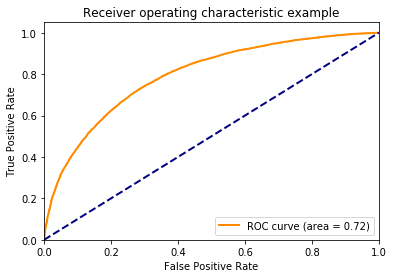

In [24]:
getROC(testY, predictions, proba)

In [25]:
getMC(testY, predictions)

[[13178  4031]
 [ 5410 10953]]


In [26]:
coefficientModel

array([[-0.60777394,  3.26244643, -2.67486042, -0.57024802, -1.68953805,
         1.0891699 , -0.0068442 , -0.0068442 ]])

#### Le AIC, en utilisant la méthode récursive à diminuer, par contre, l'accuracy rester le même. Le % du test est de 70,5% ce qui est bien pour un modèle et le nombr de bon résultats est égale à 344 +252= 596.

# 2) Arbre de decision

In [27]:
def calculModelArbreDecision(X,Y):
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.30, random_state = 0)
    ModeleArbre = DecisionTreeClassifier()
    
    TrainFit = ModeleArbre.fit(trainX, trainY)
    
    TrainScores = ModeleArbre.score(trainX, trainY)
    print('Train score=',TrainScores)
    
    TestsScore = ModeleArbre.score(testX, testY)
    print('Test score=',TestsScore)
    
    predictions = ModeleArbre.predict(testX)
    
    proba = ModeleArbre.predict_proba(testX)[:,1]
    
    mse = mean_squared_error(testY, predictions)
    aic = calculate_aic(len(testY),mse,len(X.T))
    print('AIC score :',aic)
    return predictions, TrainScores, TestsScore, aic, testY, testX, proba, trainY, trainX, ModeleArbre

In [28]:
predictions, TrainScores, TestsScoretree, aic, testY, testX, prob, trainY, trainX, model = calculModelArbreDecision(X, Y)

Train score= 1.0
Test score= 0.6684737281067556
AIC score : -37031.106873166966


Pour l'echantillon d'entrainement

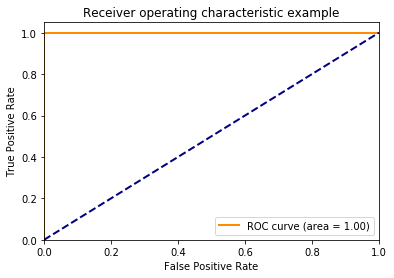

In [29]:
getROC(trainY, model.predict(trainX), model.predict_proba(trainX)[:,1])

In [30]:
getMC(trainY, model.predict(trainX))

[[40382     0]
 [    0 37951]]


Pour l'echantillon test

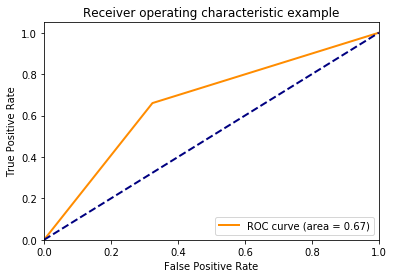

In [31]:
getROC(testY, predictions, prob)

In [32]:
getMC(testY, predictions)

[[11639  5570]
 [ 5560 10803]]


Avec les variables sélectionnées par le modèle Logit

In [33]:
nouvellePredictions, nouveauTrainScores, nouveauTestsScore, nouveauAIC, nouveautestY, nouveautestX, prob, nouveauTrainY, nouveautrainX, nouveauModel = calculModelArbreDecision(nouvelleBD, Y)

Train score= 1.0
Test score= 0.6388955081615632
AIC score : -34180.03336340535


Pour l'echantillon d'entrainement

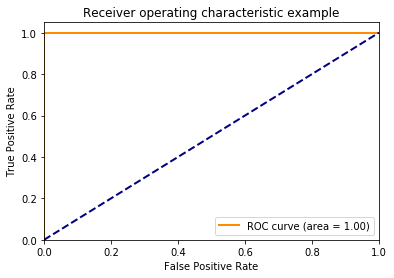

In [34]:
getROC(nouveauTrainY, nouveauModel.predict(nouveautrainX), nouveauModel.predict_proba(nouveautrainX)[:,1])

In [35]:
getMC(nouveauTrainY, nouveauModel.predict(nouveautrainX))

[[40382     0]
 [    0 37951]]


Pour l'echantillon test

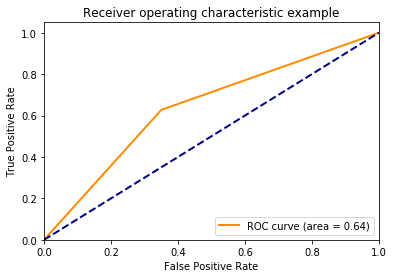

In [36]:
getROC(nouveautestY, nouvellePredictions, prob)

In [37]:
getMC(nouveautestY, nouvellePredictions)

[[11184  6025]
 [ 6098 10265]]


### Diminution de la précision de 2% lorsqu'on utilise les paramètres sélectionnés par l'arbre de décision

# Random Forest

In [38]:
def calculModelRandomForest(X,Y):
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.30, random_state = 42)
    ModeleRF = RandomForestClassifier()
    
    TrainFit = ModeleRF.fit(trainX, trainY)
    
    TrainScores = ModeleRF.score(trainX, trainY)
    print('Train score=',TrainScores)
    
    TestsScore = ModeleRF.score(testX, testY)
    print('Test score=',TestsScore)
    
    predictions = ModeleRF.predict(testX)
    
    proba = ModeleRF.predict_proba(testX)[:,1]
    
    mse = mean_squared_error(testY, predictions)
    aic = calculate_aic(len(testY),mse,len(X.T))
    print('AIC score :',aic)
    variableImportante = ModeleRF.feature_importances_
    return predictions, TrainScores, TestsScore, aic, testY, variableImportante, proba, trainY, trainX, ModeleRF

In [39]:
predictions, TrainScores, TestsScoreforest, AIC, testY, variableImportante, prob, trainY, trainX, model = calculModelRandomForest(X, Y)

Train score= 1.0
Test score= 0.7479447158346241
AIC score : -46231.802628453064


Pour l'echantillon d'entrainement 

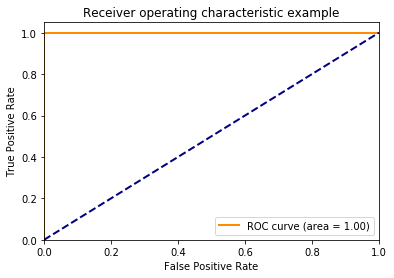

In [40]:
getROC(trainY, model.predict(trainX), model.predict_proba(trainX)[:,1])

In [41]:
getMC(trainY, model.predict(trainX))

[[40316     0]
 [    0 38017]]


Pour l'echantillon test

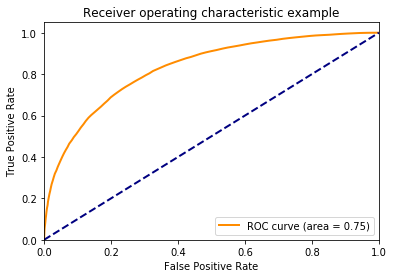

In [42]:
getROC(testY, predictions, prob)

In [43]:
getMC(testY, predictions)

[[13253  4022]
 [ 4440 11857]]


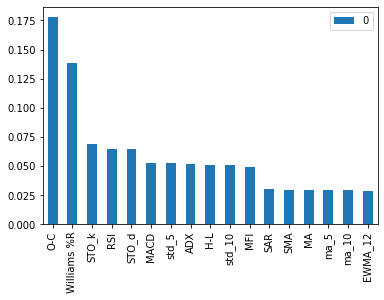

In [44]:
variableImportante1 = pd.DataFrame(variableImportante, index=X.columns)
variableImportante1.sort_values(by=0,ascending = False).plot(kind='bar')

#### Les variables importantes du Random Forest sont :
#### - O-C
#### - Williams %R
#### - Stochastique_k
#### - RSI
#### - Stochastique_d
#### Les variables importantes du Logit sont :
#### - ma_10	
#### - MACD	
#### - ma_5	
#### - EWMA_12	
#### - H-L	
##### La différence est que le modèle logit utilise des valeurs que ne varie pas beaucoup et qui sont assez stable comparativement à random forest qui choisi des variables qui bougent beaucoup

# Répétez l’exercices pour des méthodes plus flexibles mais opaques.

In [45]:
from sklearn.svm import SVC 
def calculModelSVM(X,Y,typ):
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.30, random_state = 42)
    ModeleSVM = SVC(kernel=typ)
    
    TrainFit = ModeleSVM.fit(trainX, trainY)
    
    TrainScores = ModeleSVM.score(trainX, trainY)
    print('Train score=',TrainScores)
    
    TestsScore = ModeleSVM.score(testX, testY)
    print('Test score=',TestsScore)
    
    #proba = ModeleSVM.predict_proba(testX)[:,1]
    
    mse = mean_squared_error(testY, predictions)
    aic = calculate_aic(len(testY),mse,len(X.T))
    print('AIC score :',aic)
    return predictions, TrainScores, TestsScore, aic, testY, proba, trainY, trainX, ModeleSVM

In [46]:
predictions, TrainScores, TestsScorelin, aic, testY, prob, trainY, trainX, ModeleSVM = calculModelSVM(X,Y,'linear')

Train score= 0.7150881493112736
Test score= 0.7103240795901347
AIC score : -46231.802628453064


Pour l'echantillon test

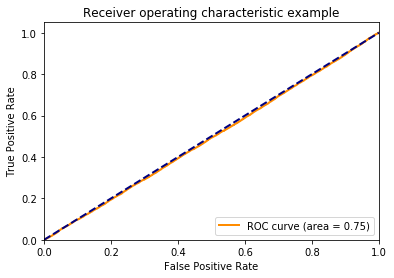

In [47]:
getROC(testY, predictions, prob)

In [48]:
getMC(testY, predictions)

[[13253  4022]
 [ 4440 11857]]


In [49]:
predictions, TrainScores, TestsScoreradial, aic, testY, prob, trainY, trainX, model = calculModelSVM(X,Y,'rbf')

Train score= 0.7372244137209094
Test score= 0.7300131061598951
AIC score : -46231.802628453064


Pour l'echantillon test

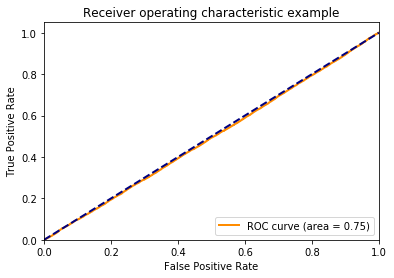

In [50]:
getROC(testY, predictions, prob)

In [51]:
getMC(testY, predictions)

[[13253  4022]
 [ 4440 11857]]


# Comparer une dernière fois, l’ensemble des modèles, sélectionnez-en un et expliquez votre choix.

In [52]:
accuracy = pd.DataFrame([TestsScorelogit,TestsScoreforest,TestsScoretree, TestsScoreradial,TestsScorelin],
                       index = ['Logit','Forest','Tree','Radial','Linéaire'], columns = ['%Tests'])*100
accuracy

,%Tests
Logit,71.878351
Forest,74.794472
Tree,66.847373
Radial,73.001311
Linéaire,71.032408


#### Le modèle le plus précis est celui du random forest avec 72 %. Il fait tout les possibilités possibles ce qui rend son modele précis dans ce cas.

# Répétez l’exercice mais cette fois-ci pour chaque ETF pris individuellement.

In [53]:
modele_unique = pd.DataFrame(index = BLack_ETF)
testscore=[]
AIC = []
for etf in BLack_ETF:
    Y,Data = get_Data_bin(etf)
    X = data_preprocessing(etf,Data)
    X['Y']=Y
    X = X.dropna()
    Y = X['Y']
    X = X.drop(columns = ['Y'])
    predictions, TrainScores, TestsScoreforest, aic, testY, variableImportante, prob, trainY, trainX, model = calculModelRandomForest(X, Y)
    testscore.append(TestsScoreforest)
    AIC.append(aic)
modele_unique['test %']=testscore
modele_unique['AIC']=AIC


[*********************100%***********************]  1 of 1 completed
Train score= 1.0
Test score= 0.6879194630872483
AIC score : -660.0384200378805
[*********************100%***********************]  1 of 1 completed
Train score= 1.0
Test score= 0.7080536912751678
AIC score : -699.7864792390891
[*********************100%***********************]  1 of 1 completed
Train score= 1.0
Test score= 0.7164429530201343
AIC score : -717.1638034767967
[*********************100%***********************]  1 of 1 completed
Train score= 1.0
Test score= 0.7399328859060402
AIC score : -768.7020678870775
[*********************100%***********************]  1 of 1 completed
Train score= 1.0
Test score= 0.7164429530201343
AIC score : -717.1638034767967
[*********************100%***********************]  1 of 1 completed
Train score= 1.0
Test score= 0.6963087248322147
AIC score : -676.2792069365164
[*********************100%***********************]  1 of 1 completed
Train score= 1.0
Test score= 0.711409395973

In [54]:
modele_unique

,test %,AIC
IVV,0.687919,-660.038420
IWF,0.708054,-699.786479
IJH,0.716443,-717.163803
IJR,0.739933,-768.702068
IWM,0.716443,-717.163803
IWD,0.696309,-676.279207
ITOT,0.711409,-706.676729
IVW,0.689597,-663.251366
IWB,0.681208,-647.357091
IWR,0.687919,-660.038420


En utilisant un modele pour chaque ETF, il est évident que le modèle sera moins efficace pour généraliser sur les autres ETF, donc il faudrait créer un modèle a chaque fois qu'on veut savoir pour un stock.

Source :

https://github.com/mrjbq7/ta-lib

https://medium.com/@rbhatia46/using-svm-on-top-of-technical-indicators-to-predict-reliance-stock-prices-abb494d9f45f